<h1>Содержание проекта<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных,-изучение-информации" data-toc-modified-id="Загрузка-данных,-изучение-информации-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных, изучение информации</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-LogisticRegression" data-toc-modified-id="Модель-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель LogisticRegression</a></span></li><li><span><a href="#Модель-DecisionTreeClassifier" data-toc-modified-id="Модель-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель DecisionTreeClassifier</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** обучить модель классифицировать комментарии на позитивные и негативные. 

В нашем распоряжении набор данных с разметкой о токсичности правок.

**Критерий качества модели:** значение метрики *F1* не меньше 0.75. 

Загрузка библиотек:

In [1]:
!pip install spacy==2.3.5 -q
!python -m spacy download en -q

бЁ¬ў®«ЁзҐбЄ п ббл«Є  б®§¤ ­  ¤«п C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\spacy\data\en <<===>> C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\en_core_web_sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Linking successful
C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\en_core_web_sm -->
C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\spacy\cli\download.py:86: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz#egg=en_core_web_sm==2.3.1 contains an egg fragment with a non-PEP 508 name. pip 25.2 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/13157


In [2]:
!pip install wordcloud==1.8.2.2 -q
!pip install Pillow==9.5.0 -q

In [3]:
!pip install shap -q
!pip install numba --upgrade -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re
import spacy
import en_core_web_sm

import tqdm
from tqdm import notebook, tqdm

from wordcloud import WordCloud

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', 200)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

RANDOM_STATE=42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Подготовка данных

### Загрузка данных, изучение информации

Загружаем данные и сохраняем в датарейм df:

In [5]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [6]:
display(df.sample(10))
df.info()

,text,toxic
79655,about English \n\nhey Athenean \nfrom turkey with Love\nalso nice madals,0
50964,It is still there. i have tryed to go to the page to delete the rey sabu match but on the edit page it doesn't show up. yet it is still seen on the main page. why is this,0
39566,You've been reported for vandalism here.,0
78619,"""\n\n SOCKPUPPETS, 'Richard Weiss,' SqueakBox, and Billy Weiss! \n\nTalk about 'sockpuppets' - SqueakBox IS the below 'user David.' HE also is the person who represented himself to me on Gmail as...",0
130872,Youngest person running for president \nSomebody please mention hes the youngest person running for president of 2008. Hes way younger then the rest of those old bags.,0
119091,"Excuse my ignorance on this one, but I really don't understand the difficulty your having with my contributions. I'm sure you're not disputing the fact that Robert Kearney is an alumnus of Clongow...",0
71104,""" (""""Well, how the heck did you miss that 'he had an appreciation for the national beverage, rakı, and consumed it at official dinners. in reforms section? If you knew that he subscribed to Playbo...",0
113540,"Lucky? I will prove that you are wrong. This artist has been targeted. Do you listen? I think not. I don't think you even know what you are doing. I know that for certain, actually. Why are you tr...",0
30467,The project wasn't vandalised. I simply edited the user list to removed 3 members who were considered bad faith. Erwin,0
128583,Worthless Settler Goof Says,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


**Описание данных**:

- 'text' - текст комментария;
- 'toxic' - бинарный признак: 0 - негативный комментарий, 1 - положительный комментарий (целевой признак).

**Вывод**: 

В датафрейме 159292 строки, 2 столбца. Пропусков нет, наименование столбцов корректное. 

### Предобработка данных

**Проверка наличия явных дубликатов:**

In [7]:
print(f'''Количество явных дубликатов: {df.duplicated().sum()}''')

Количество явных дубликатов: 0


**Анализ баланса классов целевого признака:**

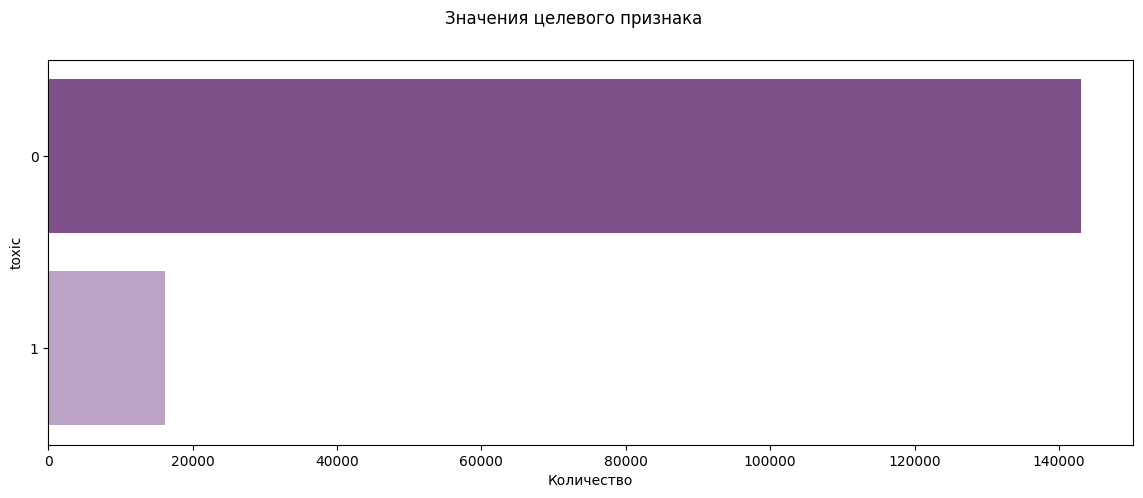

,Разметка токсичности,"Доля, %"
0,0,89.838787
1,1,10.161213


In [8]:
plt.figure(figsize=(14, 5))
sns.set_palette('PRGn')
sns.countplot(data=df, y=df['toxic'])
plt.xlabel('Количество')
plt.suptitle('Значения целевого признака')
plt.show()

df_1 = df['toxic'].value_counts(normalize=True) * 100
df_1.rename_axis('Разметка токсичности').reset_index(name='Доля, %')

Имеем дисбаланс целевого признака 'toxic' с перевесом в пользу класса 0 (почти 90%). Этот факт требуется учесть при делении датафрейма на обучающую и тестовую выборки.

**Очищаем текст:**

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'(?:\n|\r)', ' ', text)
    text = re.sub(r'(^a-z\s )', '', text)
    return text

Добавляем очищенный текст в датафрейм для дальнейшей лемматизации:

In [10]:
df['clean_text'] = df['text'].apply(clean_text)

df.sample(5)

,text,toxic,clean_text
152936,"let me tell you little man, a personal attack will be when I find you and beat the hell out of you. Be very glad I don't know where you live or where I can find you.",1,"let me tell you little man, a personal attack will be when i find you and beat the hell out of you. be very glad i don't know where you live or where i can find you."
43883,why people are insulting hazara people and keep changing their page with wrong info did any hazara come to change your pag ? the answer would be no so please be respectful and stop changing other ...,0,why people are insulting hazara people and keep changing their page with wrong info did any hazara come to change your pag ? the answer would be no so please be respectful and stop changing other ...
73984,"""\n\nYea you are right! I didn't see that picture anywhere els, at Superherohype and Countingdown. But some guy posted that picture at Countindown.com (message board)\n\nThe person that created th...",0,""" yea you are right! i didn't see that picture anywhere els, at superherohype and countingdown. but some guy posted that picture at countindown.com (message board) the person that created that p..."
148040,"""\n\n Raëlian Church \n\n You have been blocked from editing for a period of 24 hours for vandalizing Wikipedia. If you wish to make useful contributions, you are welcome to come back after the ...",0,""" raëlian church you have been blocked from editing for a period of 24 hours for vandalizing wikipedia. if you wish to make useful contributions, you are welcome to come back after the bloc..."
129579,"Childish comments\nIrishguy, may I ask why you felt is was necessary to leave those childish comments on my userpage? I really don't see the need to use personal attacks on me, you should know bet...",1,"childish comments irishguy, may i ask why you felt is was necessary to leave those childish comments on my userpage? i really don't see the need to use personal attacks on me, you should know bett..."


**Лемматизируем текст:**

In [11]:
def spacy_lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

Добавляем лемматизированный текст в датафрейм для дальнейшей работы:

In [12]:
nlp = spacy.load('en')

tqdm.pandas()
df['lemm_text'] = df['clean_text'].progress_apply(spacy_lemmatize)

df.sample(5)

100%|██████████████████████████████████████████████████████████████████████████| 159292/159292 [32:45<00:00, 81.06it/s]


,text,toxic,clean_text,lemm_text
92244,'Oriental studies put Mohammed as the founder of Islam but the Islamic faith regards him as one of the prophets and the last messenger of God.'Anyway if no one is interested then we can leave the ...,0,'oriental studies put mohammed as the founder of islam but the islamic faith regards him as one of the prophets and the last messenger of god.'anyway if no one is interested then we can leave the ...,' oriental study put mohammed as the founder of islam but the islamic faith regard -PRON- as one of the prophet and the last messenger of god . 'anyway if no one be interested then -PRON- can leav...
97881,You sure do know a lot about Arabic should I revert my move ?,0,you sure do know a lot about arabic should i revert my move ?,-PRON- sure do know a lot about arabic should i revert -PRON- move ?
49663,"Reply to Tony Fox \nHi, tony. You are correct about wiki's policy. As such, I will provide the adequate references to my additions to the punk rock article. However, when I do, it is understood t...",0,"reply to tony fox hi, tony. you are correct about wiki's policy. as such, i will provide the adequate references to my additions to the punk rock article. however, when i do, it is understood th...","reply to tony fox hi , tony . -PRON- be correct about wiki 's policy . as such , i will provide the adequate reference to -PRON- addition to the punk rock article . however , when i do , -PRON..."
61294,"""\n\nIt is part of the Harrison County Park system, just like the Corydon Battlefield, and its website is http://www.harrisoncoparks.com/BTP.html Seek his grace """,0,""" it is part of the harrison county park system, just like the corydon battlefield, and its website is http://www.harrisoncoparks.com/btp.html seek his grace """,""" -PRON- be part of the harrison county park system , just like the corydon battlefield , and -PRON- website be http://www.harrisoncoparks.com/btp.html seek -PRON- grace """
130142,"23:19, 8 January 2012",0,"23:19, 8 january 2012","23:19 , 8 january 2012"


Проведем **частотный анализ текста**, для этого используем облако слов. Получим общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных комментариях:

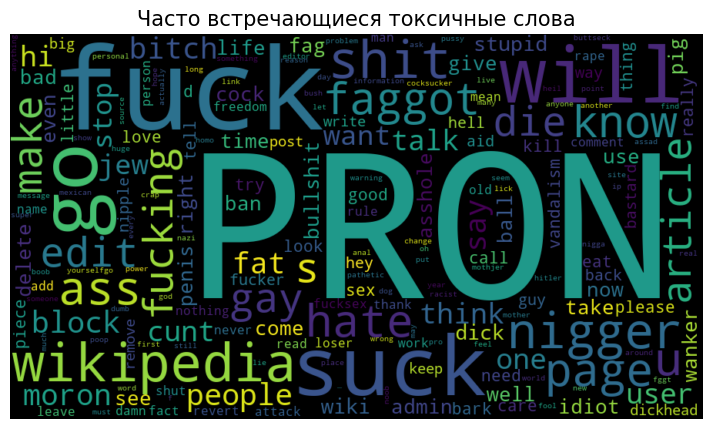

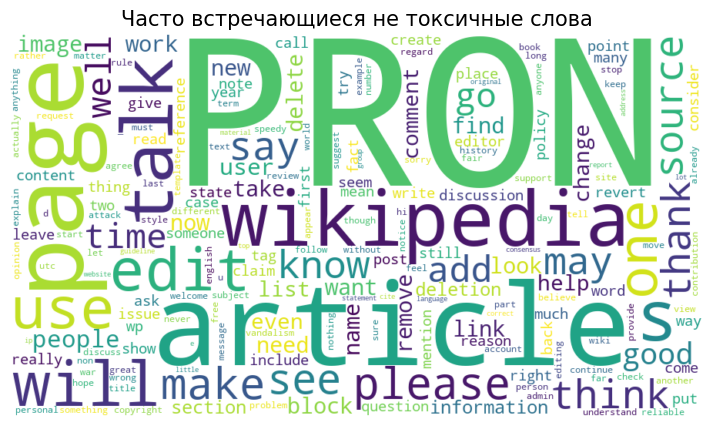

In [13]:
toxic_text = " ".join(df[df['toxic'] == 1]['lemm_text'].tolist())
non_toxic_text = " ".join(df[df['toxic'] == 0]['lemm_text'].tolist())

wordcloud_toxic = WordCloud(width=900, height=500, background_color='black', collocations=False).generate(toxic_text)
wordcloud_non_toxic = WordCloud(width=900, height=500, background_color='white', collocations=False).generate(non_toxic_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.title('Часто встречающиеся токсичные слова', fontsize=15)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.title('Часто встречающиеся не токсичные слова', fontsize=15)
plt.axis('off')
plt.show()

**Разделение на признаки:**

Делим данные на выборки: тренировочную и тестовую в соотношении 4:1. Используем стратификацию по целевому признаку (из-за дисбаланса классов):

In [14]:
# Входной признак
X = df['lemm_text']

# Целевой признак
y = df['toxic']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y)

# Проверяем разделение на выборки:
print(f'''
Размерность X_train: {X_train.shape}
Размерность X_test: {X_test.shape}
Размерность y_train: {y_train.shape}
Размерность y_test: {y_test.shape}''')


Размерность X_train: (127433,)
Размерность X_test: (31859,)
Размерность y_train: (127433,)
Размерность y_test: (31859,)


Данные подготовлены, можно приступать к моделированию.

**Вывод:** на этапе предобработке данных было выполнено:

- проверка наличия явных дубликатов - не выявлено;
- анализ баланса классов целевого признака - имеется дисбаланс целевого признака 'toxic' с перевесом в пользу класса 0. Этот факт требуется учесть на последующих этапах;
- очистка и лемматизация текста. Очищенный и лематизированный тексты добавлены в датафрейм;
- разделение на признаки - данные разделены на выборки: тренировочную и тестовую в соотношении 4:1. Используем стратификацию по целевому признаку (из-за дисбаланса классов);
- визуализация часто встречающиеся токсичных и не токсичных слов (облако слов).

### Вывод

**В разделе "Подготовка данных" было выполнено:**

- **Загрузка данных, изучение информации.** 
  - загружен файл с данными, сохранен в датафрейм. Описание данных:
   - 'text' - текст комментария;
   - 'toxic' - бинарный признак: 0 - негативный комментарий, 1 - положительный комментарий (целевой признак).
  - в датафрейме 159292 строки, 2 столбца. Пропусков нет, наименование столбцов корректное. 
  
  
- **Предобработка данных.**
  - проверка наличия явных дубликатов - не выявлено;
  - анализ баланса классов целевого признака - имеется дисбаланс целевого признака 'toxic' с перевесом в пользу класса 0. Этот факт требуется учесть на последующих этапах;
  - очистка и лемматизация текста. Очищенный и лематизированный тексты добавлены в датафрейм;
  - разделение на признаки - данные разделены на выборки: тренировочную и тестовую в соотношении 4:1. Используем стратификацию по целевому признаку (из-за дисбаланса классов);
  - визуализация часто встречающиеся токсичных и не токсичных слов (облако слов).

## Обучение моделей

### Модель LogisticRegression

Инициализируем модель логистической регрессии и находим лучшие гиперпараметры модели с помощью автоматизированого поиска GridSearchCV, в качестве метрики используем F1. Используем пайплайн:

In [16]:
pipeline = Pipeline([
    ('vector', TfidfVectorizer(max_features=10000, stop_words='english', sublinear_tf=True)),
    ('lr', LogisticRegression(random_state=RANDOM_STATE))
])

# словарь для модели LogisticRegression()
param_grid_lr = {'lr__solver': ('liblinear', 'saga','newton-cg', 'lbfgs'),
              'lr__C': (.1, 1, 5, 10),
              'lr__max_iter': ([200]),
              'lr__class_weight': ([None, 'balanced'])}

# запускаем поиск гиперпараметров
grid_search_lr = GridSearchCV(
    pipeline,
    param_grid_lr,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector',
                                        TfidfVectorizer(max_features=10000,
                                                        stop_words='english',
                                                        sublinear_tf=True)),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': (0.1, 1, 5, 10),
                         'lr__class_weight': [None, 'balanced'],
                         'lr__max_iter': [200],
                         'lr__solver': ('liblinear', 'saga', 'newton-cg',
                                        'lbfgs')},
             scoring='roc_auc')

In [17]:
print('Лучшая модель и её параметры LogisticRegression:', grid_search_lr.best_params_)
print('Лучшая метрика при кросс-валидации F1:', grid_search_lr.best_score_.round(3))

Лучшая модель и её параметры LogisticRegression: {'lr__C': 1, 'lr__class_weight': None, 'lr__max_iter': 200, 'lr__solver': 'newton-cg'}
Лучшая метрика при кросс-валидации F1: 0.97


Сохраняем лучшую обученную модель:

In [18]:
best_lr = grid_search_lr.best_estimator_

print(f'''Лучшая обученная модель: {best_lr} ''')

Лучшая обученная модель: Pipeline(steps=[('vector',
                 TfidfVectorizer(max_features=10000, stop_words='english',
                                 sublinear_tf=True)),
                ('lr',
                 LogisticRegression(C=1, max_iter=200, random_state=42,
                                    solver='newton-cg'))]) 


**Вывод**: обучена модель логистической регрессии и найдены лучшие гиперпараметры с помощью автоматизированого поиска GridSearchCV, в качестве метрики выбрана мера F1.

**Выбрана лучшая модель с гиперпараметрами: LogisticRegression (C=1, max_iter=200, random_state=42, solver='newton-cg')**. 

**Метрика F1 на кросс-валидации: 0.97**.

### Модель DecisionTreeClassifier

Инициализируем модель дерева решений и находим лучшие гиперпараметры модели с помощью автоматизированого поиска GridSearchCV, в качестве метрики используем F1. Применяем пайплайн:

In [19]:
pipeline = Pipeline([
    ('vector', TfidfVectorizer(max_features=10000, stop_words='english', sublinear_tf=True)),
    ('tree', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Cловарь для модели DecisionTreeClassifier()
param_grid_tree = {'tree__max_depth': ([x for x in range(2, 30)]),
                   'tree__class_weight': ([None, 'balanced'])}

# Запускаем поиск гиперпараметров
grid_search_tree = GridSearchCV(
    pipeline,
    param_grid_tree,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vector',
                                        TfidfVectorizer(max_features=10000,
                                                        stop_words='english',
                                                        sublinear_tf=True)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__class_weight': [None, 'balanced'],
                         'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29]},
             scoring='f1')

In [20]:
print('Лучшая модель и её параметры DecisionTreeClassifier:', grid_search_tree.best_params_)
print('Лучшая метрика при кросс-валидации F1:', grid_search_tree.best_score_.round(3))

Лучшая модель и её параметры DecisionTreeClassifier: {'tree__class_weight': None, 'tree__max_depth': 28}
Лучшая метрика при кросс-валидации F1: 0.69


Сохраняем лучшую обученную модель:

In [21]:
best_tree = grid_search_tree.best_estimator_

print(f'''Лучшая обученная модель: {best_tree} ''')

Лучшая обученная модель: Pipeline(steps=[('vector',
                 TfidfVectorizer(max_features=10000, stop_words='english',
                                 sublinear_tf=True)),
                ('tree',
                 DecisionTreeClassifier(max_depth=28, random_state=42))]) 


**Вывод**: обучена модель дерева решений и найдены лучшие гиперпараметры с помощью автоматизированого поиска GridSearchCV, в качестве метрики выбрана мера F1.

**Выбрана лучшая модель с гиперпараметрами: DecisionTreeClassifier (max_depth=28, random_state=42)**. 

**Метрика F1 на кросс-валидации: 0.69**.

### Вывод

**В разделе "Обучение моделей" было выполнено** обучение моделей и поиск лучших гиперпараметров с помощью автоматизированого поиска GridSearchCV, пайплайна, в качестве метрики выбрана мера F1:

- лучшая модель **LogisticRegression** с гиперпараметрами: C=1, max_iter=200, random_state=42, solver='newton-cg'. **Метрика F1 на кросс-валидации: 0.97.**

- лучшая модель **DecisionTreeClassifier** с гиперпараметрами: max_depth=28, random_state=42. **Метрика F1 на кросс-валидации: 0.69.**

## Тестирование моделей

Сохраним результаты обучения моделей в таблицу:

In [22]:
df_model = pd.DataFrame(columns=['F1 на кросс-валидации'])
df_model.loc['LogisticRegression'] = [grid_search_lr.best_score_.round(3)]
df_model.loc['DecisionTreeClassifier'] = [grid_search_tree.best_score_.round(3)]
df_model

,F1 на кросс-валидации
LogisticRegression,0.97
DecisionTreeClassifier,0.69


Среди двух моделей (LogisticRegression и DecisionTreeClassifier) лучшая по качеству - LogisticRegression с гиперпараметрами: C=10, max_iter=200, random_state=42, solver='lbfgs'.

Сделаем предсказание на тестовой выборке лучшей моделью и рассчитаем метрику F1 на тестовых данных:

In [23]:
y_pred_lr_test = best_lr.predict(X_test)

f1_test_lr = f1_score(y_test, y_pred_lr_test)

print(f'Метрика F1 модели LogisticRegression на тестовых данных: {f1_test_lr:.3f}')

Метрика F1 модели LogisticRegression на тестовых данных: 0.754


**Критерий качества - метрика F1 > 0.75 - достигнут**.

**Лучшая модель по качеству на тестовых данных - LogisticRegression(C=1, max_iter=200, random_state=42, solver='newton-cg'). Метрика F1 на тестовой выборке: 0.754.**

**Анализ важности признаков**. Оценим важность признаков для лучшей модели, построим график важности с помощью метода SHAP:

In [24]:
best_pipeline = best_lr

vectorizer = best_pipeline.named_steps['vector']
model = best_pipeline.named_steps['lr']

X_train_tfidf = vectorizer.transform(X_train)

explainer = shap.LinearExplainer(model, X_train_tfidf, feature_perturbation="interventional")

X_test_tfidf = vectorizer.transform(X_test)
shap_values = explainer.shap_values(X_test_tfidf)

C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


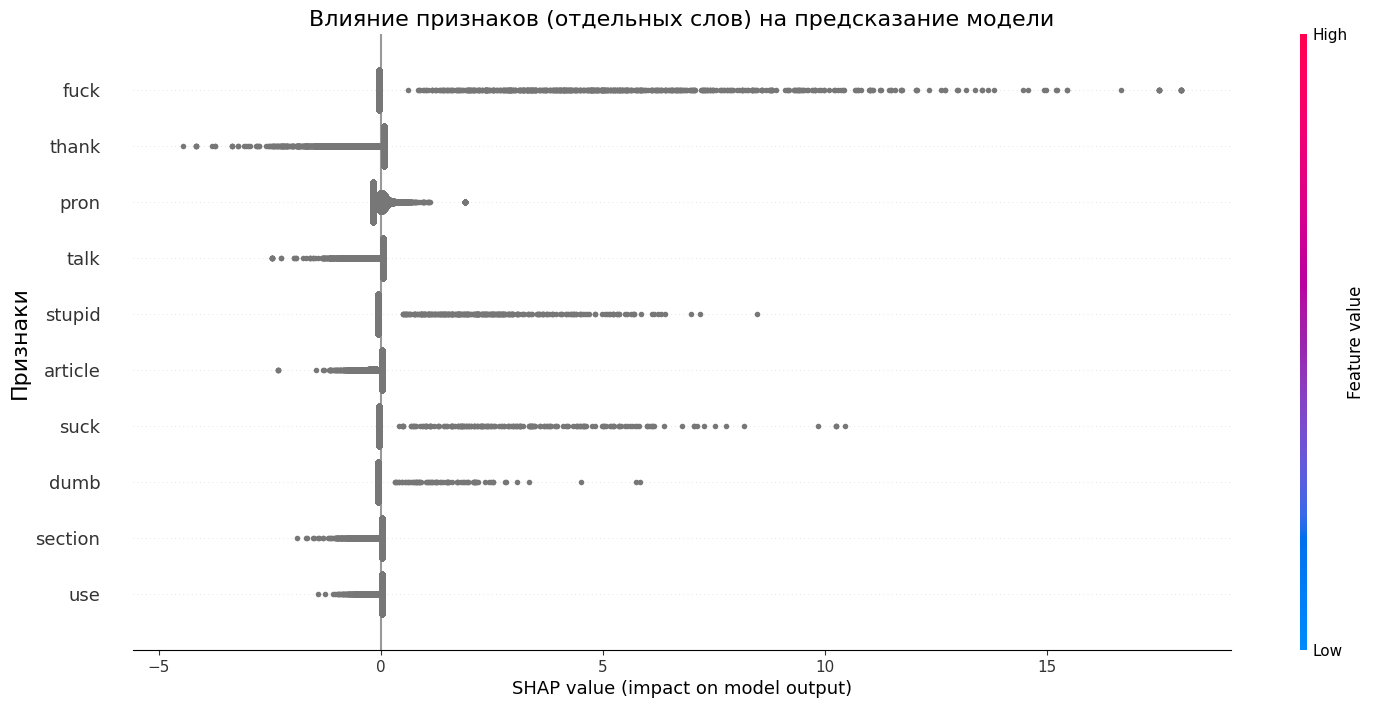

In [25]:
shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out(), 
                  plot_size=(15, 7), show=False, max_display=10)

plt.ylabel('Признаки', fontsize=16)
plt.title('Влияние признаков (отдельных слов) на предсказание модели', fontsize=16)
plt.show()

Данный график отображает вклад каждого признака в предсказания модели по всему набору тестовых данных: 
- Каждая точка – отдельное наблюдение;
- Признаки расположены на оси Oy по мере уменьшения их важности;
- По оси Ox находятся значения Шепли, которые влияют на отнесение к классу либо положительно, либо отрицательно.

Видно, какие слова сильно способствуют предсказанию комментария как токсичного. Эти слова оказывают большое влияние на выход модели, смещая предсказание в сторону токсичного класса.

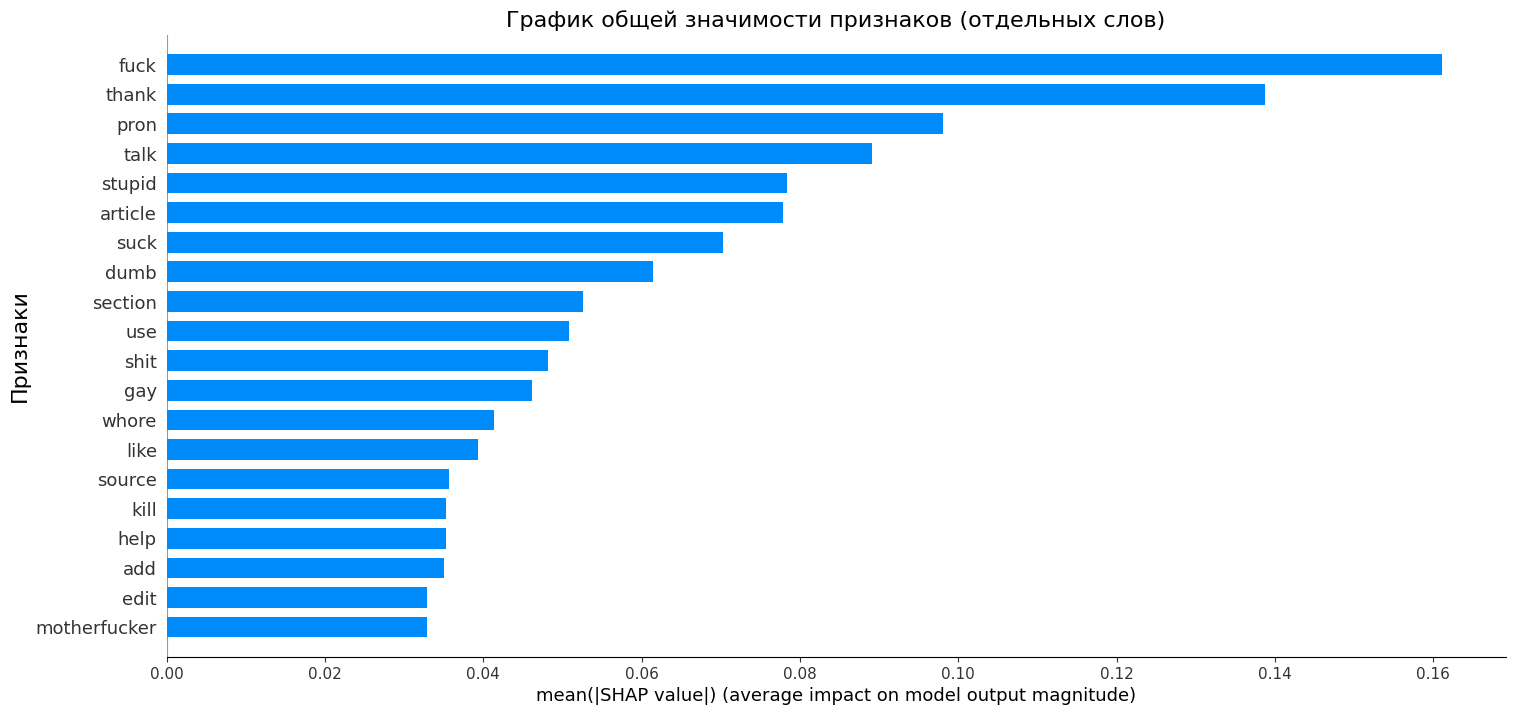

In [26]:
shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out(), plot_type='bar', 
                  plot_size=(15, 7), show=False)

plt.ylabel('Признаки', fontsize=16)
plt.title('График общей значимости признаков (отдельных слов)', fontsize=16)
plt.show()

На графике общей значимости признаков можно увидеть самые значимые признаки (отдельные слова) для модели.

**Вывод:** на данном этапе было выполнено:

- выведена сводная таблица со значениями метрик для каждой модели;
- выбрана лучшая модель из обученных;
- сделано предсказание на тестовой выборке лучшей моделью и рассчитана метрика F1 на тестовых данных.

   Таким образом, **лучшая модель по качеству - LogisticRegression(C=1, random_state=42, solver='newton-cg').**
   
   **Метрика F1 на тестовых данных: 0.754. Критерий качества - метрика F1 > 0.75 - достигнут**.
   
   
- анализ важности признаков. Построены графики важности с помощью метода SHAP:
  - влияние признаков (отдельных слов) на предсказание модели;
  - график общей значимости признаков (отдельных слов).

## Общий вывод

**РЕАЛИЗАЦИЯ ЗАДАЧИ ПО ЭТАПАМ**:

1. **Подготовка данных:**

- **Загрузка данных, изучение информации.** 
  - загружен файл с данными, сохранен в датафрейм. Описание данных:
   - 'text' - текст комментария;
   - 'toxic' - бинарный признак: 0 - негативный комментарий, 1 - положительный комментарий (целевой признак).
  - в датафрейме 159292 строки, 2 столбца. Пропусков нет, наименование столбцов корректное. 
  
  
- **Предобработка данных.**
  - проверка наличия явных дубликатов - не выявлено;
  - анализ баланса классов целевого признака - имеется дисбаланс целевого признака 'toxic' с перевесом в пользу класса 0. Этот факт требуется учесть на последующих этапах;
  - очистка и лемматизация текста. Очищенный и лематизированный тексты добавлены в датафрейм;
  - разделение на признаки - данные разделены на выборки: тренировочную и тестовую в соотношении 4:1;
  - визуализация часто встречающихся токсичных и не токсичных слов (облако слов).
  
2. **Обучение моделей**.

Выполнено обучение моделей и поиск лучших гиперпараметров с помощью автоматизированого поиска GridSearchCV, в качестве метрики выбрана мера F1. Использован пайплайн:

- лучшая модель **LogisticRegression** с гиперпараметрами: C=1, max_iter=200, random_state=42, solver='newton-cg'. **Метрика F1 на кросс-валидации: 0.97.**

- лучшая модель **DecisionTreeClassifier** с гиперпараметрами: max_depth=28, random_state=42. **Метрика F1 на кросс-валидации: 0.69.**

3. **Тестирование моделей**.

- выведена сводная таблица со значениями метрик на кросс-валидации для каждой модели;
- выбрана лучшая модель из обученных;
- сделано предсказание на тестовой выборке лучшей моделью и рассчитана метрика F1 на тестовых данных.

   Таким образом, **лучшая модель классификации комментариев на позитивные и негативные - LogisticRegression(C=1, max_iter=200, random_state=42, solver='newton-cg').**
   
   **Метрика F1 на тестовых данных: 0.754. Критерий качества - метрика F1 > 0.75 - достигнут**.
   
   
- анализ важности признаков. Построены графики важности с помощью метода SHAP:
  - влияние признаков (отдельных слов) на предсказание модели;
  - график общей значимости признаков (отдельных слов).